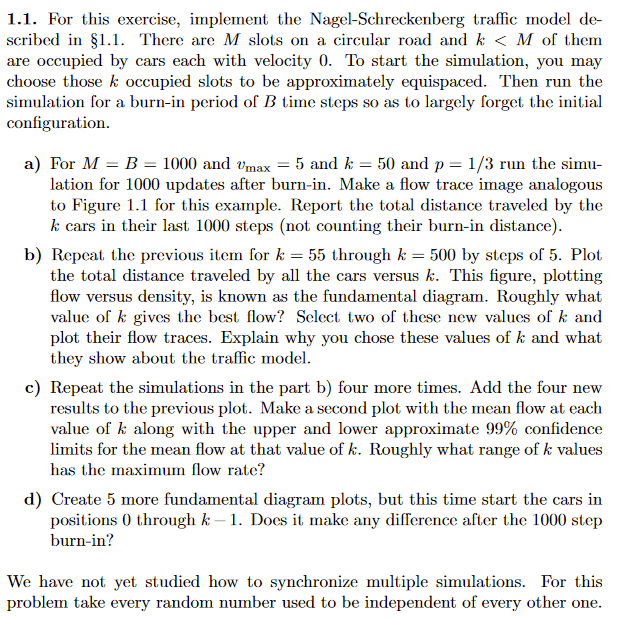

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statistics
from functools import
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

In [49]:
class car:
    def __init__(self, x0, v0=0):
        self.x_history = [x0] # history of xs. Append to update. Index -1 to get current.
        self.v_history = [v0]
        
    def count_pass_zero(self): # count the number of times the car has 'looped around'
        count = 0
        for x_index in range(1, len(self.x_history)): # check all but the first
            if self.x_history[x_index] < self.x_history[x_index - 1]:
                count += 1
        return count  # note: this will only work if v_max < M
        
    def get_distance_traveled(self):
        d_traveled = (self.x_history[-1] - self.x_history[0] 
                      + self.count_pass_zero()*1000)   ## ------- is this (x1000) where the absurdly high distances come from?
        return d_traveled

class NS_traffic:
    def __init__(self, M= 1000, k=50, v_max=5, p=1/3, seed = 97987231166, seeded = True, evenly_spaced = True):
        self.M = M # number of zones in roadway (positions for cars to be in)
        self.k = k# number of cars
        self.v_max = v_max # speed limit for cars 
        self.p = p # probability of random slowing
        self.cars = []
        self.seeded = seeded
        
        if seeded:
            self.seed = seed
        
        if evenly_spaced:
            initial_spacing = self.M/self.k
            carpos = 0
        
            for i in range(k):
                self.cars.append(car(int(carpos)))
                carpos += initial_spacing
        else:
            carpos = 0
            for i in range(k):
                self.cars.append(car(int(carpos)))
                carpos += 1
            
    def get_car_xs(self): # gets a sorted list of car positions
        self.all_xs = []
        for vehicle in self.cars:
            self.all_xs.append(vehicle.x_history[-1]) 
        self.all_xs.sort()
        
    def update(self):
        self.get_car_xs()  # this is going to be slow to do every time
        for car in self.cars:
            index = self.all_xs.index(car.x_history[-1]) # get index of current car

            if index == len(self.all_xs) - 1: # if the last item in the list
                nextcarx = self.all_xs[0] # next car x is first item on the list
            else:
                nextcarx = self.all_xs[index+1]
                
            distance = nextcarx - car.x_history[-1]
            if distance < 0:
                distance = distance + self.M
            
            new_v = min(car.v_history[-1] + 1, self.v_max)
            new_v = min(new_v, distance - 1)
                        
            if random.random() < self.p:
                new_v = max(0, new_v - 1)
            
            car.v_history.append(new_v)
            
        for car in self.cars:
            new_x = car.x_history[-1] + car.v_history[-1]
            if new_x > self.M - 1:
                new_x = new_x - (self.M)               ## -------- should this be minus 999 or 1000? 1000 - fixed.
            car.x_history.append(new_x)
    
    def burn_in(self, B = 1000, reset_history = True):
        for i in range(B): # number of cycles
            self.update()
            
        if reset_history:
            for car in self.cars:
                car.x_history = [car.x_history[-1]]
                car.v_history = [car.v_history[-1]]
                
    def print_xs(self): 
        self.get_car_xs()
        print(self.all_xs)
        
    def get_roadway_pixels(self): # gets pixel line representing car positions
        self.get_car_xs()
        line = np.zeros(self.M)
        for x in self.all_xs:
            line[x] = 1
        return line
            
    def simulate(self, cycles=1000, burn_in = True):
        if self.seeded:
            random.seed(self.seed)
        if burn_in:
            self.burn_in()  ## note that this does not support custom burn-in yet
        self.grid = np.empty((cycles, self.M))
        for i in range(cycles):
            self.grid[i] = self.get_roadway_pixels()
            self.update()
                    
    def plot_simulation(self, cycles=1000, burn_in = True):
        self.simulate(cycles, burn_in = burn_in)
        imgplot = plt.imshow(self.grid, cmap = "Greys")
        return imgplot
    
    def get_total_distance(self):
        total = 0
        for car in self.cars:
            total += car.get_distance_traveled()
        return total
        
def plot_fundamental(kvals, seeded = True, evenly_spaced = True):
    distances = np.empty(len(kvals))
    i = 0
    for K in kvals:
        model = NS_traffic(k = K, seeded = seeded, evenly_spaced = evenly_spaced)
        model.simulate()
        distances[i] = model.get_total_distance()
        i += 1
    plt.plot(kvals, distances)   ## ---------- could separate out this functionality
    
def plot_n_fundamentals(kvals, n, evenly_spaced = True):
    for i in range(n):
        plot_fundamental(kvals, seeded = False, evenly_spaced = evenly_spaced)
        
def mean_flow_at_k(k, num_sims = 10):
    total_distances = []
    for i in range(num_sims):
        NS_i = NS_traffic(k = k, seeded = False)
        NS_i.simulate()
        total_distances.append(NS_i.get_total_distance() / k) # record the distance travelled per car for a certain simulation
        
    return (sum(total_distances) / len(total_distances), statistics.stdev(total_distances))

def get_mean_flows_for_kvals(kvals, num_sims = 10):
    mean_flows = []
    stdevs = []
    for k in kvals:
        mean_flow, stdev_flow = mean_flow_at_k(k = k, num_sims = num_sims)
        mean_flows.append(mean_flow)
        stdevs.append(stdev_flow)
    return mean_flows, stdevs

def plot_mean_flows_for_kvals(kvals, num_sims = 10): # plot mean flow for kvals with 99% confidence interval
    flows, stdevs = get_mean_flows_for_kvals(kvals = kvals, num_sims = num_sims)
    # confidence interval (z = 2.576)
    ci = [sd * 2.576 for sd in stdevs]
    upper_ci = [flowval + cival for (flowval, cival) in zip(flows, ci)]
    lower_ci = [flowval - cival for (flowval, cival) in zip(flows, ci)]
    # plot
    plt.plot(kvals, flows)
    plt.fill_between(kvals, upper_ci, lower_ci, color='blue', alpha=0.1)
    

## Part (a)
### Flow trace image

Direction of travel is to the right

In [10]:
NS1 = NS_traffic(k=103)

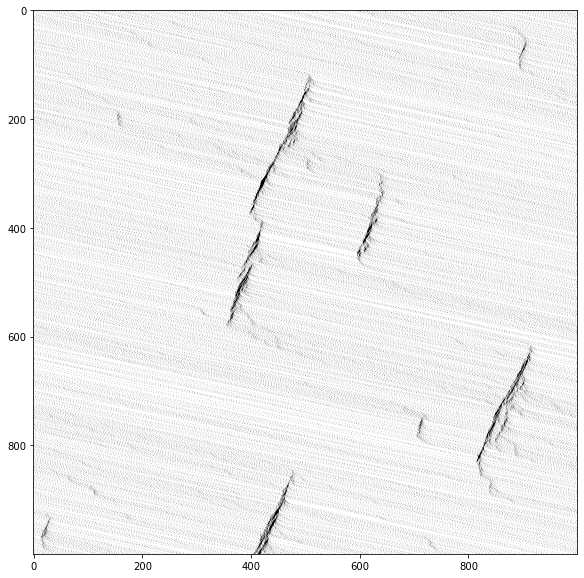

In [634]:
NS1.plot_simulation()

### Total distance traveled

In [610]:
NS1.get_total_distance()

278298

In [611]:
NS1.cars[30].count_pass_zero()

1

This was too high for only 1000 periods of simulation - fixed. 

## Part (b)


In [11]:
KVALS = list(range(55,505,5))

In [12]:
plot_fundamental(KVALS)

KeyboardInterrupt: 

In [ ]:
NSb1 = NS_traffic(k = 50) # ------ plot the extra figures as in question

### Interpretation

Total distance seems to increase linearly up to around 100 cars, as no significant jams form (although there are small ones.)

After around 100 cars, flow decreases as more cars are added. 

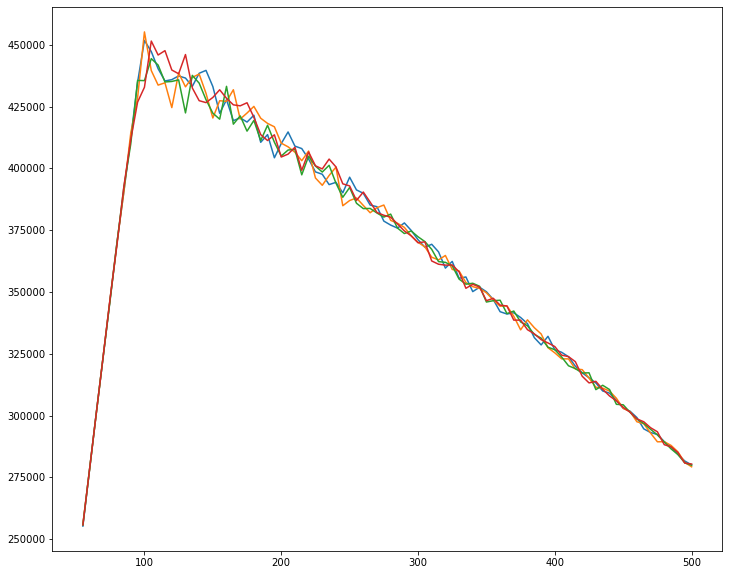

In [649]:
 plot_n_fundamentals(KVALS, 4)

For reference, as running this takes at least 20 minutes:
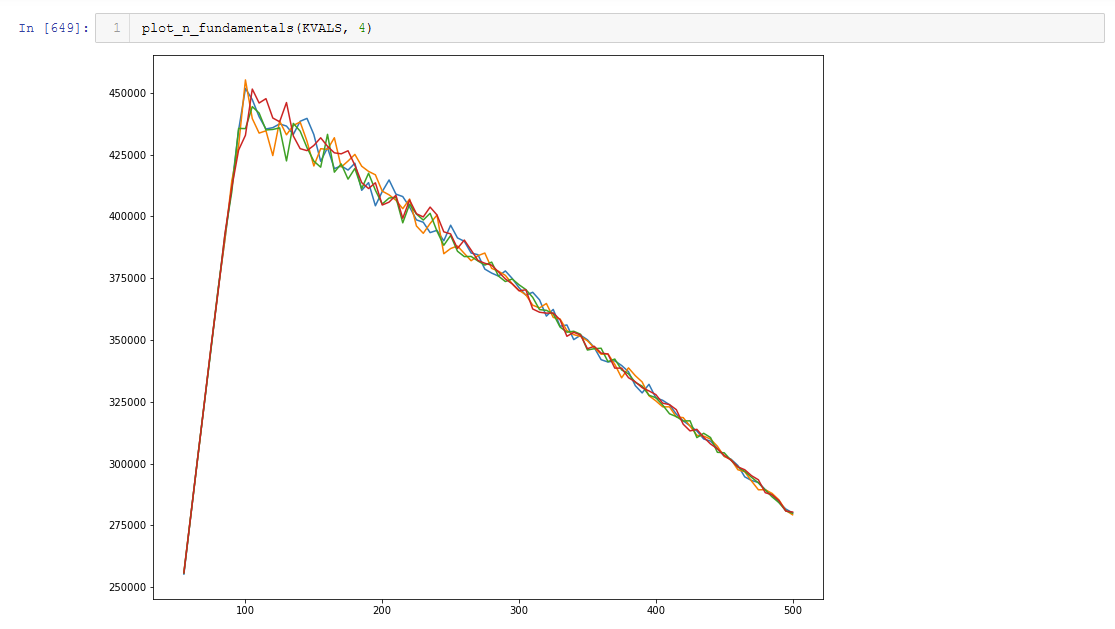
Looks like optimum in those cases was 100 or 105.

## Part (c)

In [22]:
mean_flow_at_k(100)

(4457.714999999999, 60.76213427053982)

In [38]:
KVALS2 = list(range(55, 505, 5))

In [27]:
get_mean_flows_for_kvals(KVALS2, num_sims = 4)

([4638.778571428571,
  4626.6875,
  4590.519444444445,
  4519.0625,
  3978.588636363637,
  3611.5270833333334],
 [1.3641423509816117,
  3.4543903224735675,
  20.93470620449024,
  45.153042994538716,
  120.79188563387129,
  47.85636078267024])

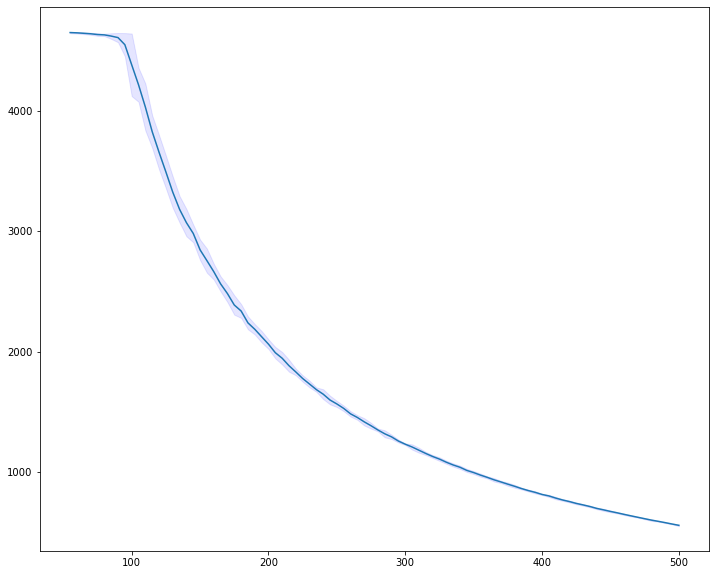

In [39]:
plot_mean_flows_for_kvals(KVALS2, num_sims = 10)

#### Note to self
Have functions that save data to memory so that can mess around with plotting without resimulatiing.

## Part (d)

In [42]:
KVALS3 = list(range(50, 80, 10))

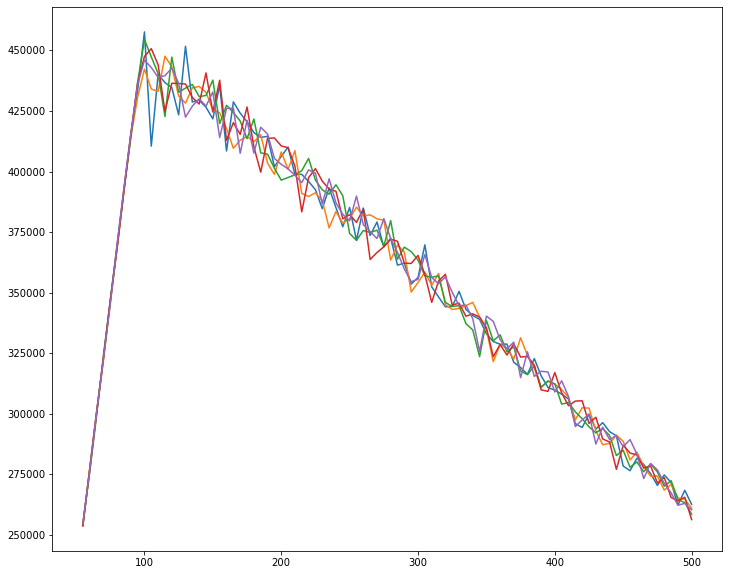

In [46]:
 plot_n_fundamentals(KVALS, 5, evenly_spaced = False)

Initial spacing doesn't seem to make much of a difference

hello


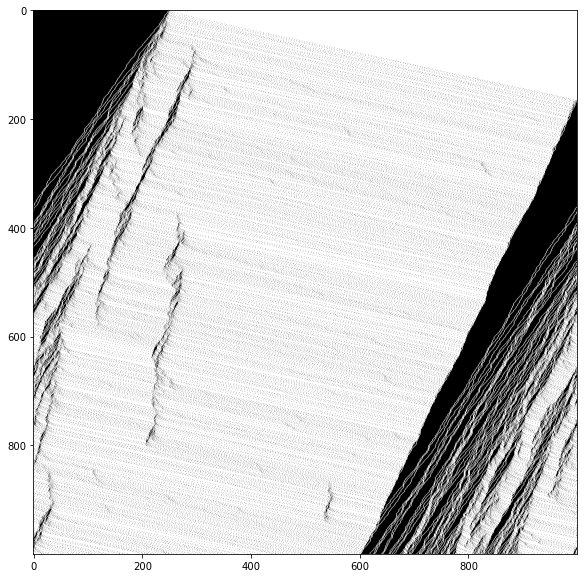

In [54]:
NS1 = NS_traffic(k=250, evenly_spaced = False)
NS1.plot_simulation(burn_in = False)

print("hello")